<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/base_models_gnn_mamba_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# V8: GNN-Mamba for Monthly Precipitation Prediction

## State Space Models + Graph Neural Networks

**Innovation**: First application of Mamba SSM to regional precipitation prediction

### Architecture Overview

| Component | V4 (Baseline) | V8 (This Model) |
|-----------|---------------|------------------|
| Spatial Encoder | GNN (GAT) | GNN (GAT) |
| Temporal Encoder | LSTM + Attention | **Mamba SSM** |
| Complexity | O(T) LSTM | O(T) Mamba |
| Memory | Fixed cells | **Selective** |
| Fusion | Concatenation | **Cross-Attention** |

### Expected Improvements
- Better long-range dependencies (60 months input)
- Automatic seasonal pattern capture
- More efficient memory usage

### Target Metrics
| Metric | V4 Baseline | V8 Target |
|--------|-------------|----------|
| R2 | 0.596 | > 0.62 |
| RMSE | 84.37 mm | < 82 mm |

## 1. Environment Setup

In [1]:
# ============================================================
# SECTION 1: ENVIRONMENT SETUP
# ============================================================

import os
import sys
import json
from pathlib import Path

# Detect environment
IN_COLAB = 'google.colab' in sys.modules
SEED = 42

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')

    # Install dependencies
    import torch
    TORCH_VERSION = torch.__version__.split('+')[0]
    CUDA_VERSION = torch.version.cuda
    if CUDA_VERSION:
        CUDA_TAG = f"cu{CUDA_VERSION.replace('.', '')}"
    else:
        CUDA_TAG = 'cpu'

    print(f"PyTorch: {TORCH_VERSION}")
    print(f"CUDA: {CUDA_VERSION}")

    # Install torch_geometric
    try:
        import torch_geometric
        print(f"PyG already installed: {torch_geometric.__version__}")
    except ImportError:
        print("Installing PyTorch Geometric...")
        pyg_url = f"https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_TAG}.html"
        !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f $pyg_url
        !pip install torch-geometric

    # Install Mamba
    print("\nInstalling Mamba SSM...")
    !pip install mamba-ssm causal-conv1d>=1.1.0 --quiet

    # Other dependencies
    !pip install netCDF4 xarray dask h5netcdf --quiet

    print("\nEnvironment versions:")
    print(sys.version)
    print(torch.__version__)
    print(torch.version.cuda)

    env_info = {
        'python': sys.version,
        'torch': torch.__version__,
        'cuda': torch.version.cuda
    }
    try:
        import torch_geometric
        env_info['torch_geometric'] = torch_geometric.__version__
        print(f"PyG: {torch_geometric.__version__}")
    except Exception:
        print("PyG: not available")
    try:
        import mamba_ssm
        env_info['mamba_ssm'] = mamba_ssm.__version__
        print(f"Mamba-SSM: {mamba_ssm.__version__}")
    except Exception:
        print("Mamba-SSM: not available")

    env_dir = BASE_PATH / 'models' / 'output' / 'env_versions'
    env_dir.mkdir(parents=True, exist_ok=True)
    env_path = env_dir / 'v8_env_versions.json'
    with open(env_path, 'w') as f:
        json.dump(env_info, f, indent=2)
    print(f"Saved environment versions to: {env_path}")

else:
    BASE_PATH = Path(r'd:\github.com\ninja-marduk\ml_precipitation_prediction')

print(f"\nBase path: {BASE_PATH}")
print(f"Running in: {'Google Colab' if IN_COLAB else 'Local Environment'}")

Mounted at /content/drive
PyTorch: 2.9.0
CUDA: 12.6
Installing PyTorch Geometric...
Looking in links: https://data.pyg.org/whl/torch-2.9.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=3869128 sha256=caf86dc437d8480b0067c424f034843043f7f404cf32e1a1866ca9f54399b98c
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=3038314 sha256=ceae2e43d252ef5790a6a12dd7ae101b081661446d8aae2

In [2]:
# ============================================================
# SECTION 1.1: IMPORTS
# ============================================================

import json
import sys
import gc
import copy
import warnings
import math
from datetime import datetime
from dataclasses import dataclass, field, asdict
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any, Literal

import numpy as np
import pandas as pd
import xarray as xr

# Matplotlib setup
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# PyTorch Geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data, Batch

# Scikit-learn
from sklearn.cluster import KMeans
from scipy import stats

# Mamba SSM
PREFER_OFFICIAL_MAMBA = True
REQUIRE_OFFICIAL_MAMBA = False
USE_OFFICIAL_MAMBA = False
MAMBA_BACKEND = "custom"
try:
    from mamba_ssm import Mamba
    if PREFER_OFFICIAL_MAMBA:
        USE_OFFICIAL_MAMBA = True
        MAMBA_BACKEND = "official"
        print("Using official mamba-ssm package for Mamba blocks")
    else:
        print("Official mamba-ssm available but disabled; using custom implementation")
except ImportError as e:
    if REQUIRE_OFFICIAL_MAMBA:
        raise RuntimeError(
            "mamba-ssm not available but REQUIRE_OFFICIAL_MAMBA=True. "
            "Install mamba-ssm or set REQUIRE_OFFICIAL_MAMBA=False."
        ) from e
    print("Official mamba-ssm not available, using custom implementation (slower; may trigger CUDA timeout on Windows)")

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

warnings.filterwarnings('ignore')

Official mamba-ssm not available, using custom implementation (slower; may trigger CUDA timeout on Windows)

Device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB


## 2. Configuration

In [3]:
# ============================================================
# SECTION 2: CONFIGURATION
# ============================================================

@dataclass
class V8Config:
    """V8 GNN-Mamba Configuration."""

    # === Data Configuration ===
    input_window: int = 60          # 5 years of monthly data
    horizon: int = 12               # Predict 12 months ahead
    train_val_split: float = 0.8

    # Light mode for testing
    light_mode: bool = False
    light_grid_size: int = 10

    # Enabled horizons
    enabled_horizons: List[int] = field(default_factory=lambda: [12])

    # Grid dimensions (updated after loading)
    n_lat: int = 61
    n_lon: int = 65
    n_nodes: int = 61 * 65

    # === Model Dimensions ===
    hidden_dim: int = 64            # Main hidden dimension
    n_features: int = 5             # Input features

    # === GNN Configuration (Spatial) ===
    gnn_type: str = 'GAT'           # GAT, SAGE, or GCN
    gnn_num_layers: int = 3
    gnn_num_heads: int = 4
    gnn_dropout: float = 0.1

    # === MAMBA Configuration (Temporal) ===
    mamba_d_state: int = 16         # SSM state dimension
    mamba_d_conv: int = 4           # Causal conv kernel size
    mamba_expand: int = 2           # Inner dimension expansion
    mamba_num_layers: int = 2       # Number of Mamba blocks
    mamba_bidirectional: bool = True  # Process forward + backward
    mamba_dropout: float = 0.1
    mamba_node_chunk: int = 256    # Nodes per temporal chunk (0 = disable)

    # === Cross-Modal Attention ===
    cross_attn_heads: int = 4
    cross_attn_dropout: float = 0.1

    # === Training ===
    epochs: int = 100
    batch_size: int = 4
    learning_rate: float = 1e-3
    weight_decay: float = 1e-5
    patience: int = 15
    gradient_clip: float = 1.0

    # === Physics Loss (from V7) ===
    use_physics_loss: bool = True
    lambda_mass_conservation: float = 0.05
    lambda_orographic: float = 0.1
    high_elev_threshold: float = 3000.0

    # === Scheduler ===
    scheduler_type: str = 'cosine'  # 'plateau' or 'cosine'
    cosine_T0: int = 20
    cosine_T_mult: int = 2

    # === Output ===
    output_dir: str = 'V8_GNN_Mamba'
    save_checkpoints: bool = True

    # === Data handling ===
    allow_missing_features: bool = True

    # === Outputs / Diagnostics ===
    export_predictions: bool = True
    export_history: bool = True
    plot_graph_diagnostics: bool = True
    plot_results_summary: bool = True
    plot_metrics_table: bool = True
    generate_map_plots: bool = True
    map_export_horizon: int = 1
    map_export_max_samples: int = 3

    # === Quality checks / gates ===
    enforce_quality_gates: bool = False
    quality_neg_pred_max: float = 0.01
    quality_nan_max: float = 0.0
    quality_bias_pct_max: float = 25.0


# Feature sets
FEATURE_SETS = {
    'BASIC': ['total_precipitation'],
    'KCE': ['total_precipitation', 'elev_low', 'elev_med', 'elev_high'],
    'FULL': ['total_precipitation', 'elevation', 'slope', 'aspect',
             'elev_low', 'elev_med', 'elev_high']
}

# Initialize config
CONFIG = V8Config()

# Adjust for Colab memory constraints
if IN_COLAB:
    CONFIG.batch_size = 2
    CONFIG.hidden_dim = 48
    CONFIG.mamba_d_state = 12
    CONFIG.gnn_num_heads = 2
    print("Adjusted config for Colab memory constraints")

print("\n=== V8 GNN-Mamba Configuration ===")
print(f"  Input window: {CONFIG.input_window} months")
print(f"  Horizon: {CONFIG.horizon} months")
print(f"  Hidden dim: {CONFIG.hidden_dim}")
print(f"  Mamba d_state: {CONFIG.mamba_d_state}")
print(f"  Mamba bidirectional: {CONFIG.mamba_bidirectional}")
print(f"  GNN type: {CONFIG.gnn_type}")
print(f"  Batch size: {CONFIG.batch_size}")

Adjusted config for Colab memory constraints

=== V8 GNN-Mamba Configuration ===
  Input window: 60 months
  Horizon: 12 months
  Hidden dim: 48
  Mamba d_state: 12
  Mamba bidirectional: True
  GNN type: GAT
  Batch size: 2


## 3. Mamba Implementation

### State Space Model Basics

Mamba is based on the continuous-time state space model:

$$h'(t) = Ah(t) + Bx(t)$$
$$y(t) = Ch(t) + Dx(t)$$

**Key innovation**: A, B, C are **input-dependent** (selective), allowing the model to:
- Focus on relevant information
- Forget irrelevant context
- Maintain O(n) complexity

In [4]:
# ============================================================
# SECTION 3: MAMBA IMPLEMENTATION
# ============================================================

class MambaBlock(nn.Module):
    """
    Selective State Space Model Block.

    Based on: "Mamba: Linear-Time Sequence Modeling with Selective State Spaces"

    Key components:
    - Input-dependent (selective) SSM parameters
    - Gated architecture with SiLU activation
    - Causal 1D convolution
    """

    def __init__(
        self,
        d_model: int,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
        dropout: float = 0.1
    ):
        super().__init__()

        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.d_inner = d_model * expand

        # Input projection (splits into x and z for gating)
        self.in_proj = nn.Linear(d_model, self.d_inner * 2, bias=False)

        # Causal 1D convolution (depthwise)
        self.conv1d = nn.Conv1d(
            in_channels=self.d_inner,
            out_channels=self.d_inner,
            kernel_size=d_conv,
            padding=d_conv - 1,
            groups=self.d_inner  # Depthwise separable
        )

        # SSM parameters projection (input-dependent B, C, dt)
        self.x_proj = nn.Linear(self.d_inner, d_state * 2 + 1, bias=False)

        # A is log-parametrized for numerical stability
        A = torch.arange(1, d_state + 1, dtype=torch.float32)
        self.A_log = nn.Parameter(torch.log(A))

        # D is the skip connection coefficient
        self.D = nn.Parameter(torch.ones(self.d_inner))

        # Output projection
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False)

        # Normalization and dropout
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, d_model)
        Returns:
            y: (batch, seq_len, d_model)
        """
        batch, seq_len, _ = x.shape
        residual = x

        # Project and split for gating
        xz = self.in_proj(x)  # (B, L, 2*d_inner)
        x_branch, z = xz.chunk(2, dim=-1)  # Each: (B, L, d_inner)

        # Causal 1D convolution
        x_conv = x_branch.transpose(1, 2)  # (B, d_inner, L)
        x_conv = self.conv1d(x_conv)[:, :, :seq_len]  # Truncate to maintain causality
        x_conv = x_conv.transpose(1, 2)  # (B, L, d_inner)
        x_conv = F.silu(x_conv)

        # Selective SSM
        y = self.ssm(x_conv)

        # Gating with z
        z = F.silu(z)
        output = y * z

        # Output projection + residual
        output = self.out_proj(output)
        output = self.dropout(output)
        output = self.norm(output + residual)

        return output

    def ssm(self, x: torch.Tensor) -> torch.Tensor:
        """
        Selective State Space Model computation.

        Discretized SSM:
            h_t = A_bar * h_{t-1} + B_bar * x_t
            y_t = C * h_t + D * x_t
        """
        batch, seq_len, d_inner = x.shape
        device = x.device

        # Project to get input-dependent B, C, dt
        x_proj = self.x_proj(x)  # (B, L, d_state*2 + 1)

        # Split projections
        B = x_proj[:, :, :self.d_state]  # (B, L, d_state)
        C = x_proj[:, :, self.d_state:2*self.d_state]  # (B, L, d_state)
        dt = F.softplus(x_proj[:, :, -1:])  # (B, L, 1) - positive timestep

        # A from log-parametrization (negative for stability)
        A = -torch.exp(self.A_log.float())  # (d_state,)

        # Discretize: A_bar = exp(A * dt)
        A_bar = torch.exp(
            A.view(1, 1, self.d_state) * dt
        )  # (B, L, d_state)

        # B_bar = B * dt (simplified discretization)
        B_bar = B * dt  # (B, L, d_state)

        # Sequential scan (can be parallelized with associative scan)
        h = torch.zeros(batch, d_inner, self.d_state, device=device)
        outputs = []

        for t in range(seq_len):
            # State update: h_t = A_bar * h_{t-1} + B_bar * x_t
            h = h * A_bar[:, t, :].unsqueeze(1) + \
                x[:, t, :].unsqueeze(-1) * B_bar[:, t, :].unsqueeze(1)
            # h: (B, d_inner, d_state)

            # Output: y_t = C * h_t
            y_t = (h * C[:, t, :].unsqueeze(1)).sum(dim=-1)  # (B, d_inner)
            outputs.append(y_t)

        y = torch.stack(outputs, dim=1)  # (B, L, d_inner)

        # Skip connection with D
        y = y + x * self.D.view(1, 1, -1)

        return y


class OfficialMambaBlock(nn.Module):
    """
    Wrapper around the official mamba-ssm Mamba module with residual + norm.

    Uses the official CUDA kernels when available.
    """

    def __init__(
        self,
        d_model: int,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
        dropout: float = 0.1
    ):
        super().__init__()

        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        y = self.mamba(x)
        y = self.dropout(y)
        return self.norm(y + residual)


class MambaTemporalEncoder(nn.Module):
    """
    Multi-layer bidirectional Mamba encoder for temporal sequences.

    Replaces LSTM + Temporal Attention from V4.
    Uses official mamba-ssm when available, otherwise falls back to the custom block.

    Advantages:
    - O(n) complexity (same as LSTM)
    - Selective memory (learns what to remember)
    - Parallelizable during training
    - Better long-range dependencies
    """

    def __init__(
        self,
        d_model: int,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
        n_layers: int = 2,
        bidirectional: bool = True,
        dropout: float = 0.1
    ):
        super().__init__()

        self.bidirectional = bidirectional
        self.n_layers = n_layers
        self.using_official = USE_OFFICIAL_MAMBA
        block_cls = OfficialMambaBlock if USE_OFFICIAL_MAMBA else MambaBlock

        # Forward Mamba layers
        self.forward_layers = nn.ModuleList([
            block_cls(
                d_model=d_model,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand,
                dropout=dropout
            )
            for _ in range(n_layers)
        ])

        # Backward Mamba layers (if bidirectional)
        if bidirectional:
            self.backward_layers = nn.ModuleList([
                block_cls(
                    d_model=d_model,
                    d_state=d_state,
                    d_conv=d_conv,
                    expand=expand,
                    dropout=dropout
                )
                for _ in range(n_layers)
            ])
            # Merge forward and backward
            self.merge = nn.Linear(d_model * 2, d_model)
            self.merge_norm = nn.LayerNorm(d_model)

        self.output_norm = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, d_model)
        Returns:
            h: (batch, seq_len, d_model)
        """
        # Forward pass
        h_fwd = x
        for layer in self.forward_layers:
            h_fwd = layer(h_fwd)

        if self.bidirectional:
            # Backward pass (flip, process, flip back)
            h_bwd = torch.flip(x, dims=[1])
            for layer in self.backward_layers:
                h_bwd = layer(h_bwd)
            h_bwd = torch.flip(h_bwd, dims=[1])

            # Merge forward and backward
            h = self.merge(torch.cat([h_fwd, h_bwd], dim=-1))
            h = self.merge_norm(h)
        else:
            h = h_fwd

        return self.output_norm(h)


# Test Mamba implementation
print(f"Testing Mamba implementation ({MAMBA_BACKEND})...")
test_mamba = MambaTemporalEncoder(
    d_model=CONFIG.hidden_dim,
    d_state=CONFIG.mamba_d_state,
    d_conv=CONFIG.mamba_d_conv,
    expand=CONFIG.mamba_expand,
    n_layers=CONFIG.mamba_num_layers,
    bidirectional=CONFIG.mamba_bidirectional
).to(device)

test_input = torch.randn(2, CONFIG.input_window, CONFIG.hidden_dim).to(device)
test_output = test_mamba(test_input)
print(f"  Input shape: {test_input.shape}")
print(f"  Output shape: {test_output.shape}")
print(f"  Parameters: {sum(p.numel() for p in test_mamba.parameters()):,}")
del test_mamba, test_input, test_output
torch.cuda.empty_cache() if torch.cuda.is_available() else None

Testing Mamba implementation (custom)...
  Input shape: torch.Size([2, 60, 48])
  Output shape: torch.Size([2, 60, 48])
  Parameters: 72,480


## 4. Spatial GNN Encoder

In [5]:
# ============================================================
# SECTION 4: SPATIAL GNN ENCODER
# ============================================================

class SpatialGNNEncoder(nn.Module):
    """
    Graph Neural Network for spatial encoding.

    Supports GAT, GraphSAGE, and GCN.
    Based on V4 architecture.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        num_layers: int = 3,
        gnn_type: str = 'GAT',
        num_heads: int = 4,
        dropout: float = 0.1
    ):
        super().__init__()

        self.gnn_type = gnn_type
        self.num_layers = num_layers

        # Input projection
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        # GNN layers
        self.gnn_layers = nn.ModuleList()
        self.norms = nn.ModuleList()

        for i in range(num_layers):
            if gnn_type == 'GAT':
                # GAT: multi-head attention
                self.gnn_layers.append(
                    GATConv(
                        in_channels=hidden_dim,
                        out_channels=hidden_dim // num_heads,
                        heads=num_heads,
                        dropout=dropout,
                        concat=True
                    )
                )
            elif gnn_type == 'SAGE':
                self.gnn_layers.append(
                    SAGEConv(hidden_dim, hidden_dim)
                )
            else:  # GCN
                self.gnn_layers.append(
                    GCNConv(hidden_dim, hidden_dim)
                )

            self.norms.append(nn.LayerNorm(hidden_dim))

        self.dropout = nn.Dropout(dropout)
        self.output_norm = nn.LayerNorm(hidden_dim)

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
        edge_weight: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Args:
            x: (num_nodes, input_dim) or (batch*num_nodes, input_dim)
            edge_index: (2, num_edges)
            edge_weight: (num_edges,) optional
        Returns:
            h: (num_nodes, hidden_dim)
        """
        # Input projection
        h = self.input_proj(x)

        # GNN layers with residual connections
        for i, (gnn, norm) in enumerate(zip(self.gnn_layers, self.norms)):
            h_res = h

            # GNN forward
            if self.gnn_type == 'GAT':
                h = gnn(h, edge_index)
            elif edge_weight is not None and self.gnn_type == 'GCN':
                h = gnn(h, edge_index, edge_weight)
            else:
                h = gnn(h, edge_index)

            # Activation + Normalization + Residual
            h = F.gelu(h)
            h = norm(h)
            h = self.dropout(h)
            h = h + h_res  # Residual

        return self.output_norm(h)


print("SpatialGNNEncoder defined successfully")

SpatialGNNEncoder defined successfully


## 5. GNN-Mamba V8 Main Model

In [6]:
# ============================================================
# SECTION 5: GNN-MAMBA V8 MAIN MODEL
# ============================================================

class CrossModalAttention(nn.Module):
    """
    Cross-attention between spatial (GNN) and temporal (Mamba) representations.

    Allows spatial features to attend to temporal context and vice versa.
    """

    def __init__(
        self,
        d_model: int,
        num_heads: int = 4,
        dropout: float = 0.1
    ):
        super().__init__()

        self.attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Feed-forward
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout)
        )

    def forward(
        self,
        query: torch.Tensor,
        key_value: torch.Tensor
    ) -> torch.Tensor:
        """
        Args:
            query: (batch, n_nodes, d_model) - spatial features
            key_value: (batch, n_nodes, d_model) - temporal features
        Returns:
            output: (batch, n_nodes, d_model)
        """
        # Cross-attention
        attn_out, _ = self.attn(query, key_value, key_value)
        x = self.norm1(query + attn_out)

        # Feed-forward
        x = self.norm2(x + self.ffn(x))

        return x


class GNN_Mamba_V8(nn.Module):
    """
    V8: Graph Neural Network + Mamba State Space Model

    Architecture:
    1. Input projection
    2. Parallel branches:
       - GNN: spatial encoding per timestep
       - Mamba: temporal encoding per node
    3. Cross-modal attention fusion
    4. Prediction head

    Improvements over V4:
    - Mamba replaces LSTM + Attention
    - Cross-modal attention instead of concatenation
    - Better handling of long sequences (60 months)
    """

    def __init__(self, config: V8Config):
        super().__init__()

        self.config = config

        # === Input Projection ===
        self.input_proj = nn.Sequential(
            nn.Linear(config.n_features, config.hidden_dim),
            nn.LayerNorm(config.hidden_dim),
            nn.GELU(),
            nn.Dropout(config.gnn_dropout)
        )

        # === Spatial Branch: GNN ===
        self.gnn_encoder = SpatialGNNEncoder(
            input_dim=config.hidden_dim,
            hidden_dim=config.hidden_dim,
            num_layers=config.gnn_num_layers,
            gnn_type=config.gnn_type,
            num_heads=config.gnn_num_heads,
            dropout=config.gnn_dropout
        )

        # === Temporal Branch: Mamba ===
        self.mamba_encoder = MambaTemporalEncoder(
            d_model=config.hidden_dim,
            d_state=config.mamba_d_state,
            d_conv=config.mamba_d_conv,
            expand=config.mamba_expand,
            n_layers=config.mamba_num_layers,
            bidirectional=config.mamba_bidirectional,
            dropout=config.mamba_dropout
        )

        # === Cross-Modal Fusion ===
        self.cross_attention = CrossModalAttention(
            d_model=config.hidden_dim,
            num_heads=config.cross_attn_heads,
            dropout=config.cross_attn_dropout
        )

        # === Prediction Head ===
        self.predictor = nn.Sequential(
            nn.Linear(config.hidden_dim, config.hidden_dim),
            nn.GELU(),
            nn.Dropout(config.gnn_dropout),
            nn.Linear(config.hidden_dim, config.hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(config.gnn_dropout),
            nn.Linear(config.hidden_dim // 2, config.horizon)
        )

        # Store dimensions for reshaping
        self.n_lat = config.n_lat
        self.n_lon = config.n_lon
        self.n_nodes = config.n_nodes

        self._init_weights()

    def _init_weights(self):
        """Initialize weights with Xavier/Kaiming."""
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() >= 2:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
        edge_weight: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, Dict[str, Any]]:
        """
        Forward pass.

        Args:
            x: (batch, seq_len, n_nodes, n_features) or
               (batch, seq_len, lat, lon, n_features)
            edge_index: (2, num_edges)
            edge_weight: (num_edges,) optional

        Returns:
            pred: (batch, n_nodes, horizon)
            info: dict with intermediate representations
        """
        # Handle different input shapes
        if x.dim() == 5:  # (B, T, lat, lon, F)
            batch_size, seq_len, n_lat, n_lon, n_features = x.shape
            n_nodes = n_lat * n_lon
            x = x.view(batch_size, seq_len, n_nodes, n_features)
        else:  # (B, T, N, F)
            batch_size, seq_len, n_nodes, n_features = x.shape

        # 1. Input projection
        x = self.input_proj(x)  # (B, T, N, H)

        # 2. Spatial encoding (GNN per timestep)
        h_spatial = self._encode_spatial(x, edge_index, edge_weight)
        # (B, T, N, H)

        # 3. Temporal encoding (Mamba per node)
        h_temporal = self._encode_temporal(x)
        # (B, T, N, H)

        # 4. Cross-modal fusion (at final timestep)
        h_fused = self._fuse_representations(h_spatial, h_temporal)
        # (B, N, H)

        # 5. Prediction
        pred = self.predictor(h_fused)  # (B, N, horizon)

        info = {
            'h_spatial': h_spatial[:, -1, :, :],  # Last timestep
            'h_temporal': h_temporal[:, -1, :, :],
            'h_fused': h_fused
        }

        return pred, info

    def _encode_spatial(self, x, edge_index, edge_weight):
        """Apply GNN to each timestep."""
        batch_size, seq_len, n_nodes, hidden_dim = x.shape

        # Process in chunks to save memory
        chunk_size = 10  # timesteps per chunk
        outputs = []

        for t_start in range(0, seq_len, chunk_size):
            t_end = min(t_start + chunk_size, seq_len)
            x_chunk = x[:, t_start:t_end, :, :]  # (B, chunk, N, H)

            chunk_len = t_end - t_start
            x_flat = x_chunk.reshape(batch_size * chunk_len, n_nodes, hidden_dim)

            # Apply GNN to each graph in batch
            h_list = []
            for i in range(x_flat.shape[0]):
                h_i = self.gnn_encoder(x_flat[i], edge_index, edge_weight)
                h_list.append(h_i)

            h_chunk = torch.stack(h_list, dim=0)  # (B*chunk, N, H)
            h_chunk = h_chunk.view(batch_size, chunk_len, n_nodes, hidden_dim)
            outputs.append(h_chunk)

        return torch.cat(outputs, dim=1)  # (B, T, N, H)

    def _encode_temporal(self, x):
        """Apply Mamba to each node's temporal sequence."""
        batch_size, seq_len, n_nodes, hidden_dim = x.shape

        # Chunk nodes to avoid long CUDA kernels on large grids
        chunk_size = getattr(self.config, 'mamba_node_chunk', 0) or n_nodes
        outputs = []

        for n_start in range(0, n_nodes, chunk_size):
            n_end = min(n_start + chunk_size, n_nodes)
            x_chunk = x[:, :, n_start:n_end, :]  # (B, T, chunk, H)

            # Reshape: (B, T, chunk, H) -> (B*chunk, T, H)
            x_temporal = x_chunk.permute(0, 2, 1, 3)
            x_temporal = x_temporal.reshape(batch_size * (n_end - n_start), seq_len, hidden_dim)

            # Apply Mamba
            h_temporal = self.mamba_encoder(x_temporal)  # (B*chunk, T, H)

            # Reshape back: (B*chunk, T, H) -> (B, T, chunk, H)
            h_temporal = h_temporal.view(batch_size, n_end - n_start, seq_len, hidden_dim)
            h_temporal = h_temporal.permute(0, 2, 1, 3)
            outputs.append(h_temporal)

        return torch.cat(outputs, dim=2)  # (B, T, N, H)

    def _fuse_representations(self, h_spatial, h_temporal):
        """Fuse spatial and temporal representations at final timestep."""
        # Take final timestep
        h_spatial_final = h_spatial[:, -1, :, :]  # (B, N, H)
        h_temporal_final = h_temporal[:, -1, :, :]  # (B, N, H)

        # Cross-attention: spatial queries temporal
        h_fused = self.cross_attention(h_spatial_final, h_temporal_final)

        return h_fused  # (B, N, H)


# Test model
print("\nTesting GNN_Mamba_V8...")
test_config = V8Config(
    n_features=4,
    n_lat=10,
    n_lon=10,
    n_nodes=100,
    hidden_dim=32,
    mamba_d_state=8,
    input_window=12,
    horizon=6
)

test_model = GNN_Mamba_V8(test_config).to(device)
test_x = torch.randn(2, 12, 100, 4).to(device)
test_edge_index = torch.randint(0, 100, (2, 500)).to(device)

with torch.no_grad():
    test_pred, test_info = test_model(test_x, test_edge_index)

print(f"  Input shape: {test_x.shape}")
print(f"  Output shape: {test_pred.shape}")
print(f"  Total parameters: {sum(p.numel() for p in test_model.parameters()):,}")

del test_model, test_x, test_pred, test_info
torch.cuda.empty_cache() if torch.cuda.is_available() else None
print("\nGNN_Mamba_V8 test passed!")


Testing GNN_Mamba_V8...
  Input shape: torch.Size([2, 12, 100, 4])
  Output shape: torch.Size([2, 100, 6])
  Total parameters: 52,246

GNN_Mamba_V8 test passed!


## 6. Data Loading and Preprocessing

In [7]:
# ============================================================
# SECTION 6: DATA LOADING
# ============================================================

# Paths
DATA_PATH = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
OUTPUT_ROOT = BASE_PATH / 'models' / 'output' / CONFIG.output_dir
DATA_OUT_DIR = OUTPUT_ROOT / 'data'
FIG_OUT_DIR = OUTPUT_ROOT / 'figures'
COMP_DIR = OUTPUT_ROOT / 'comparisons'
TRAIN_LOG_DIR = OUTPUT_ROOT / 'training_metrics'
MAP_OUT_DIR = OUTPUT_ROOT / 'map_exports'

for d in [OUTPUT_ROOT, DATA_OUT_DIR, FIG_OUT_DIR, COMP_DIR, TRAIN_LOG_DIR, MAP_OUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_ROOT}")
print(f"Data exists: {DATA_PATH.exists()}")

Data path: /content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc
Output path: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V8_GNN_Mamba
Data exists: True


In [8]:
# ============================================================
# SECTION 6.1: DATA FUNCTIONS
# ============================================================

def validate_dataset(ds: xr.Dataset, config: V8Config) -> Tuple[str, str]:
    """Validate dataset dimensions."""
    lat_candidates = ['latitude', 'lat', 'y']
    lon_candidates = ['longitude', 'lon', 'x']

    lat_dim = next((d for d in lat_candidates if d in ds.dims), None)
    lon_dim = next((d for d in lon_candidates if d in ds.dims), None)

    if lat_dim is None or lon_dim is None:
        raise ValueError(f"Cannot find lat/lon dims in {list(ds.dims.keys())}")

    if 'time' not in ds.dims:
        raise ValueError("Dataset must have 'time' dimension")

    # Update config
    config.n_lat = ds.dims[lat_dim]
    config.n_lon = ds.dims[lon_dim]
    config.n_nodes = config.n_lat * config.n_lon

    return lat_dim, lon_dim


def load_dataset(data_path: Path, config: V8Config) -> xr.Dataset:
    """Load and validate NetCDF dataset."""
    print(f"Loading dataset from: {data_path}")
    ds = xr.open_dataset(data_path)

    lat_dim, lon_dim = validate_dataset(ds, config)

    print(f"Dataset dimensions:")
    for dim, size in ds.dims.items():
        print(f"  - {dim}: {size}")

    print(f"Available variables: {list(ds.data_vars)}")

    if config.light_mode:
        ds = ds.isel({
            lat_dim: slice(0, config.light_grid_size),
            lon_dim: slice(0, config.light_grid_size)
        })
        config.n_lat = config.light_grid_size
        config.n_lon = config.light_grid_size
        config.n_nodes = config.n_lat * config.n_lon
        print(f"Light mode: using {config.light_grid_size}x{config.light_grid_size} grid")

    return ds, lat_dim, lon_dim


def create_elevation_clusters(ds: xr.Dataset, n_clusters: int = 3) -> xr.Dataset:
    """Add elevation cluster features (KCE)."""
    if 'elevation' not in ds:
        print("Warning: No elevation data, skipping clustering")
        return ds

    elevation = ds['elevation'].values
    elev_dims = ds['elevation'].dims

    if elevation.ndim == 3:
        elevation = elevation[0]
        elev_dims = elev_dims[-2:]

    valid_mask = ~np.isnan(elevation)
    elev_flat = elevation[valid_mask].reshape(-1, 1)

    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10)
    labels = np.full(elevation.shape, -1)
    labels[valid_mask] = kmeans.fit_predict(elev_flat)

    for i, name in enumerate(['elev_low', 'elev_med', 'elev_high']):
        cluster_data = np.zeros_like(elevation)
        cluster_data[labels == i] = 1.0
        ds[name] = xr.DataArray(data=cluster_data, dims=elev_dims)

    print("Added elevation clusters: elev_low, elev_med, elev_high")
    return ds


def build_spatial_graph(
    ds: xr.Dataset,
    lat_dim: str,
    lon_dim: str,
    k_neighbors: int = 8,
    max_edges: int = 500000
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Build spatial graph based on geographic proximity."""
    lat_vals = ds[lat_dim].values
    lon_vals = ds[lon_dim].values

    n_lat, n_lon = len(lat_vals), len(lon_vals)
    n_nodes = n_lat * n_lon

    # Create node positions
    lat_grid, lon_grid = np.meshgrid(lat_vals, lon_vals, indexing='ij')
    positions = np.stack([lat_grid.flatten(), lon_grid.flatten()], axis=1)

    # Build edges based on grid connectivity (8-connectivity)
    edges = []
    weights = []

    for i in range(n_lat):
        for j in range(n_lon):
            node_idx = i * n_lon + j

            # 8-connectivity neighbors
            neighbors = [
                (i-1, j-1), (i-1, j), (i-1, j+1),
                (i, j-1),             (i, j+1),
                (i+1, j-1), (i+1, j), (i+1, j+1)
            ]

            for ni, nj in neighbors:
                if 0 <= ni < n_lat and 0 <= nj < n_lon:
                    neighbor_idx = ni * n_lon + nj

                    # Distance-based weight
                    dist = np.sqrt(
                        (lat_vals[i] - lat_vals[ni])**2 +
                        (lon_vals[j] - lon_vals[nj])**2
                    )
                    weight = 1.0 / (dist + 1e-6)

                    edges.append([node_idx, neighbor_idx])
                    weights.append(weight)

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(weights, dtype=torch.float32)

    # Normalize weights
    edge_weight = edge_weight / edge_weight.max()

    # Limit edges if needed
    if edge_index.shape[1] > max_edges:
        top_k = torch.topk(edge_weight, max_edges).indices
        edge_index = edge_index[:, top_k]
        edge_weight = edge_weight[top_k]

    print(f"Graph built: {n_nodes} nodes, {edge_index.shape[1]} edges")

    return edge_index, edge_weight


def plot_graph_diagnostics(
    edge_index: torch.Tensor,
    edge_weight: torch.Tensor,
    output_dir: Path,
    config: V8Config
) -> None:
    """Plot simple graph diagnostics."""
    if edge_index is None or edge_weight is None:
        print('Graph diagnostics skipped: missing edge data')
        return

    src = edge_index[0].cpu().numpy() if torch.is_tensor(edge_index) else np.asarray(edge_index[0])
    weights = edge_weight.cpu().numpy() if torch.is_tensor(edge_weight) else np.asarray(edge_weight)
    degrees = np.bincount(src, minlength=config.n_nodes)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(degrees, bins=30, color='steelblue', edgecolor='black')
    axes[0].set_title('Node Degree Distribution')
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('Count')

    axes[1].hist(weights, bins=30, color='darkorange', edgecolor='black')
    axes[1].set_title('Edge Weight Distribution')
    axes[1].set_xlabel('Weight')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    fig_path = output_dir / 'v8_graph_diagnostics.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"Graph diagnostics saved to: {fig_path}")


def extract_features(
    ds: xr.Dataset,
    feature_names: List[str],
    config: V8Config
) -> Tuple[np.ndarray, List[str]]:
    """Extract features from dataset."""
    features = []
    missing = []

    for name in feature_names:
        if name in ds.data_vars:
            data = ds[name].values
            if data.ndim == 2:  # Static feature
                data = np.broadcast_to(data, (ds.dims['time'], *data.shape))
            features.append(data)
        elif config.allow_missing_features:
            print(f"Warning: Missing feature {name}")
            missing.append(name)
        else:
            raise ValueError(f"Missing feature: {name}")

    if not features:
        raise ValueError("No features extracted")

    features = np.stack(features, axis=-1)
    features = np.nan_to_num(features, nan=0.0)

    config.n_features = features.shape[-1]
    print(f"Extracted features shape: {features.shape}")

    return features.astype(np.float32), missing


def extract_elevation_vector(ds: xr.Dataset) -> Optional[np.ndarray]:
    """Extract elevation as a flat vector if available."""
    if 'elevation' not in ds:
        return None

    elevation = ds['elevation'].values
    if elevation.ndim == 3:
        elevation = elevation[0]

    elevation = np.nan_to_num(elevation, nan=0.0).astype(np.float32)
    return elevation.reshape(-1)


print("Data functions defined")

Data functions defined


In [9]:
# ============================================================
# SECTION 6.2: DATASET CLASS
# ============================================================

class V8Dataset(Dataset):
    """Dataset for V8 GNN-Mamba model."""

    def __init__(
        self,
        features: torch.Tensor,      # (time, lat, lon, n_features)
        target: torch.Tensor,         # (time, lat, lon)
        input_window: int,
        horizon: int,
        edge_index: torch.Tensor,
        edge_weight: torch.Tensor,
        start_idx: int,
        end_idx: int,
        elevation: Optional[torch.Tensor] = None
    ):
        self.features = features
        self.target = target
        self.input_window = input_window
        self.horizon = horizon
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.start_idx = start_idx
        self.end_idx = end_idx
        self.elevation = elevation

        self.n_lat = features.shape[1]
        self.n_lon = features.shape[2]
        self.n_nodes = self.n_lat * self.n_lon

    def __len__(self):
        return self.end_idx - self.start_idx

    def __getitem__(self, idx):
        i = self.start_idx + idx

        # Input sequence
        x = self.features[i:i+self.input_window]  # (T, lat, lon, F)
        x = x.reshape(self.input_window, self.n_nodes, -1)  # (T, N, F)

        # Target
        y = self.target[i+self.input_window:i+self.input_window+self.horizon]
        y = y.reshape(self.horizon, self.n_nodes)  # (H, N)
        y = y.permute(1, 0)  # (N, H)

        sample = {
            'x': x,
            'y': y,
            'edge_index': self.edge_index,
            'edge_weight': self.edge_weight
        }

        if self.elevation is not None:
            sample['elevation'] = self.elevation

        return sample


def prepare_data(ds: xr.Dataset, config: V8Config, lat_dim: str, lon_dim: str, output_dir: Path):
    """Prepare train/val datasets."""
    print("\n" + "="*60)
    print("Preparing data for V8 GNN-Mamba")
    print("="*60)

    # Add elevation clusters
    ds = create_elevation_clusters(ds)

    # Extract features
    features, missing_features = extract_features(ds, FEATURE_SETS['KCE'], config)

    # Target
    target = ds['total_precipitation'].values.astype(np.float32)
    target = np.nan_to_num(target, nan=0.0)
    print(f"Target shape: {target.shape}")

    # Build graph
    edge_index, edge_weight = build_spatial_graph(ds, lat_dim, lon_dim)

    if getattr(config, 'plot_graph_diagnostics', True):
        plot_graph_diagnostics(edge_index, edge_weight, output_dir, config)

    # Convert to tensors
    features = torch.from_numpy(features)
    target = torch.from_numpy(target)

    # Elevation vector for physics loss (optional)
    elevation_vec = extract_elevation_vector(ds)
    elevation = torch.from_numpy(elevation_vec) if elevation_vec is not None else None

    # Time split
    n_time = features.shape[0]
    max_start = n_time - config.input_window - config.horizon

    split_idx = int(max_start * config.train_val_split)

    print(f"\nData split:")
    print(f"  Total samples: {max_start + 1}")
    print(f"  Train: 0 to {split_idx}")
    print(f"  Val: {split_idx} to {max_start + 1}")

    # Create datasets
    train_dataset = V8Dataset(
        features, target,
        config.input_window, config.horizon,
        edge_index, edge_weight,
        start_idx=0, end_idx=split_idx,
        elevation=elevation
    )

    val_dataset = V8Dataset(
        features, target,
        config.input_window, config.horizon,
        edge_index, edge_weight,
        start_idx=split_idx, end_idx=max_start + 1,
        elevation=elevation
    )

    overlap_leakage = bool(split_idx < config.input_window)
    data_report = {
        'n_time': int(n_time),
        'n_lat': int(config.n_lat),
        'n_lon': int(config.n_lon),
        'n_nodes': int(config.n_nodes),
        'input_window': int(config.input_window),
        'horizon': int(config.horizon),
        'train_val_split': float(config.train_val_split),
        'train_start_idx': 0,
        'train_end_idx': int(split_idx - 1),
        'val_start_idx': int(split_idx),
        'val_end_idx': int(max_start),
        'missing_features': missing_features,
        'feature_set': FEATURE_SETS['KCE'],
        'has_elevation': bool(elevation is not None),
        'overlap_leakage': overlap_leakage,
        'target_stats': {
            'min': float(target.min().item()),
            'max': float(target.max().item()),
            'mean': float(target.mean().item()),
            'std': float(target.std().item())
        }
    }

    return train_dataset, val_dataset, edge_index, edge_weight, data_report


print("Dataset class defined")

Dataset class defined


In [10]:
# ============================================================
# SECTION 6.3: LOAD DATA
# ============================================================

# Load dataset
ds, lat_dim, lon_dim = load_dataset(DATA_PATH, CONFIG)

# Prepare data
train_dataset, val_dataset, edge_index, edge_weight, data_report = prepare_data(
    ds, CONFIG, lat_dim, lon_dim, OUTPUT_ROOT
)

print("\nData report summary:")
print(f"  Missing features: {data_report.get('missing_features', [])}")
print(f"  Overlap leakage: {data_report.get('overlap_leakage', False)}")
print(f"  Target mean: {data_report['target_stats']['mean']:.3f}")

# Move graph to device
edge_index = edge_index.to(device)
edge_weight = edge_weight.to(device)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"\nData loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

# Test batch
test_batch = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"  x: {test_batch['x'].shape}")
print(f"  y: {test_batch['y'].shape}")

Loading dataset from: /content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc
Dataset dimensions:
  - time: 518
  - latitude: 61
  - longitude: 65
Available variables: ['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'year', 'month', 'elevation', 'slope', 'aspect', 'cluster_elevation', 'total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag3', 'total_precipitation_lag4', 'total_precipitation_lag12', 'total_precipitation_lag24', 'total_precipitation_lag36', 'CEEMDAN_imf_1', 'CEEMDAN_imf_2', 'CEEMDAN_imf_3', 'CEEMDAN_imf_4', 'CEEMDAN_imf_5', 'CEEMDAN_imf_6', 'CEEMDAN_imf_7', 'CEEMDAN_imf_8', 'CEEMDAN_imf_9', 'TVFEMD_imf_1', 'TVFEMD_imf_2', 'TVFEMD_imf_3', 'TVFEMD_imf_4', 'TVFEMD_imf_5', 'TVFEMD_imf_6', 'TVFEMD_imf_7', 'TVFEMD_imf_8', 'elev_low', 'elev_med',

## 7. Training

In [11]:
# ============================================================
# SECTION 7: LOSS FUNCTIONS
# ============================================================

def physics_informed_loss(
    pred: torch.Tensor,
    target: torch.Tensor,
    elevation: Optional[torch.Tensor] = None,
    config: V8Config = None
) -> Tuple[torch.Tensor, Dict[str, float]]:
    """
    Physics-informed loss with mass conservation and orographic constraints.

    Args:
        pred: (batch, n_nodes, horizon)
        target: (batch, n_nodes, horizon)
        elevation: (n_nodes,) optional
        config: V8Config
    """
    # Base MSE loss
    mse_loss = F.mse_loss(pred, target)

    components = {'mse': mse_loss.item()}
    total_loss = mse_loss

    if config and config.use_physics_loss:
        # Mass conservation: total precipitation should be preserved
        pred_sum = pred.sum(dim=1)  # (batch, horizon)
        target_sum = target.sum(dim=1)
        mass_loss = torch.abs(pred_sum - target_sum) / (target_sum.abs() + 1e-6)
        mass_loss = mass_loss.mean()

        total_loss = total_loss + config.lambda_mass_conservation * mass_loss
        components['mass'] = mass_loss.item()

        # Orographic constraint: high elevation should have higher precipitation
        if elevation is not None:
            elev = elevation
            if elev.dim() == 2:
                elev = elev[0]
            high_elev_mask = elev > config.high_elev_threshold
            if high_elev_mask.sum() > 0:
                pred_high = pred[:, high_elev_mask, :].mean()
                target_high = target[:, high_elev_mask, :].mean()
                oro_loss = F.relu(target_high - pred_high)

                total_loss = total_loss + config.lambda_orographic * oro_loss
                components['orographic'] = oro_loss.item()

    return total_loss, components


print("Loss functions defined")

Loss functions defined


In [12]:
# ============================================================
# SECTION 7.1: TRAINING LOOP
# ============================================================

def train_v8(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: V8Config,
    output_dir: Path
) -> Dict[str, List]:
    """
    Training loop for V8 GNN-Mamba.
    """
    model = model.to(device)

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )

    # Scheduler
    if config.scheduler_type == 'cosine':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=config.cosine_T0,
            T_mult=config.cosine_T_mult
        )
    else:
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5
        )

    # History
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_mse': [],
        'val_mse': [],
        'lr': []
    }

    best_val_loss = float('inf')
    patience_counter = 0

    print("\n" + "="*60)
    print("Starting V8 GNN-Mamba Training")
    print("="*60)

    for epoch in range(config.epochs):
        # === Training ===
        model.train()
        train_loss_sum = 0.0
        train_mse_sum = 0.0
        n_batches = 0

        for batch in train_loader:
            x = batch['x'].to(device)  # (B, T, N, F)
            y = batch['y'].to(device)  # (B, N, H)
            edge_idx = batch['edge_index'][0].to(device)
            edge_wt = batch['edge_weight'][0].to(device)
            elevation = batch['elevation'].to(device) if 'elevation' in batch else None

            optimizer.zero_grad()

            # Forward
            pred, info = model(x, edge_idx, edge_wt)

            # Loss
            loss, components = physics_informed_loss(
                pred, y, elevation=elevation, config=config
            )

            # Backward
            loss.backward()

            # Gradient clipping
            if config.gradient_clip > 0:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(),
                    config.gradient_clip
                )

            optimizer.step()

            train_loss_sum += loss.item()
            train_mse_sum += components['mse']
            n_batches += 1

        avg_train_loss = train_loss_sum / n_batches
        avg_train_mse = train_mse_sum / n_batches

        # === Validation ===
        model.eval()
        val_loss_sum = 0.0
        val_mse_sum = 0.0
        val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                x = batch['x'].to(device)
                y = batch['y'].to(device)
                edge_idx = batch['edge_index'][0].to(device)
                edge_wt = batch['edge_weight'][0].to(device)
                elevation = batch['elevation'].to(device) if 'elevation' in batch else None

                pred, info = model(x, edge_idx, edge_wt)
                loss, components = physics_informed_loss(
                    pred, y, elevation=elevation, config=config
                )

                val_loss_sum += loss.item()
                val_mse_sum += components['mse']
                val_batches += 1

        avg_val_loss = val_loss_sum / val_batches
        avg_val_mse = val_mse_sum / val_batches

        # Update scheduler
        current_lr = optimizer.param_groups[0]['lr']
        if config.scheduler_type == 'cosine':
            scheduler.step()
        else:
            scheduler.step(avg_val_loss)

        # Record history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_mse'].append(avg_train_mse)
        history['val_mse'].append(avg_val_mse)
        history['lr'].append(current_lr)

        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(
                f"Epoch {epoch+1:3d}/{config.epochs}: "
                f"Train={avg_train_loss:.4f} Val={avg_val_loss:.4f} "
                f"MSE={avg_val_mse:.4f} LR={current_lr:.2e}"
            )

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0

            if config.save_checkpoints:
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': avg_val_loss,
                    'config': asdict(config)
                }
                torch.save(checkpoint, output_dir / 'v8_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= config.patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    print(f"\nTraining complete. Best val loss: {best_val_loss:.4f}")

    return history


print("Training loop defined")

Training loop defined


In [13]:
# ============================================================
# SECTION 7.2: RUN TRAINING
# ============================================================

# Initialize model
model = GNN_Mamba_V8(CONFIG)
print(f"\nModel initialized:")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Train
history = train_v8(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=CONFIG,
    output_dir=OUTPUT_ROOT
)


Model initialized:
  Total parameters: 114,996
  Trainable: 114,996

Starting V8 GNN-Mamba Training
Epoch   1/100: Train=36850.5838 Val=17465.3264 MSE=17465.2925 LR=1.00e-03
Epoch   5/100: Train=14835.3919 Val=13532.8656 MSE=13532.6598 LR=9.05e-04
Epoch  10/100: Train=13444.2968 Val=12916.4428 MSE=12915.3806 LR=5.78e-04
Epoch  15/100: Train=13089.4883 Val=12730.3601 MSE=12729.0800 LR=2.06e-04
Epoch  20/100: Train=12906.2263 Val=12567.5047 MSE=12566.1361 LR=6.16e-06
Epoch  25/100: Train=12029.9870 Val=11521.9048 MSE=11519.7824 LR=9.76e-04
Epoch  30/100: Train=11727.9696 Val=11556.9252 MSE=11554.8707 LR=8.80e-04
Epoch  35/100: Train=11360.3723 Val=10917.1165 MSE=10915.2285 LR=7.27e-04
Epoch  40/100: Train=11001.5151 Val=10675.9309 MSE=10674.5383 LR=5.39e-04
Epoch  45/100: Train=10473.1821 Val=10217.5216 MSE=10215.8846 LR=3.45e-04
Epoch  50/100: Train=10215.6173 Val=9916.2210 MSE=9914.8810 LR=1.75e-04
Epoch  55/100: Train=10068.9001 Val=9863.3522 MSE=9862.1412 LR=5.45e-05
Epoch  60/100: 

## 8. Evaluation

In [14]:
# ============================================================
# SECTION 8: EVALUATION
# ============================================================

def evaluate_model(
    model: nn.Module,
    data_loader: DataLoader,
    config: V8Config
) -> Dict[str, Any]:
    """
    Evaluate model and compute metrics per horizon.
    """
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in data_loader:
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            edge_idx = batch['edge_index'][0].to(device)
            edge_wt = batch['edge_weight'][0].to(device)

            pred, _ = model(x, edge_idx, edge_wt)

            all_preds.append(pred.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    preds = np.concatenate(all_preds, axis=0)  # (N_samples, N_nodes, H)
    targets = np.concatenate(all_targets, axis=0)

    # Compute metrics per horizon
    results = []
    for h in range(config.horizon):
        pred_h = preds[:, :, h].flatten()
        target_h = targets[:, :, h].flatten()

        # RMSE
        rmse = np.sqrt(np.mean((pred_h - target_h) ** 2))

        # MAE
        mae = np.mean(np.abs(pred_h - target_h))

        # R2
        ss_res = np.sum((target_h - pred_h) ** 2)
        ss_tot = np.sum((target_h - target_h.mean()) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8))

        # Bias
        bias = np.mean(pred_h - target_h)

        results.append({
            'H': h + 1,
            'RMSE': rmse,
            'MAE': mae,
            'R^2': r2,
            'Bias': bias
        })

    return {
        'metrics': results,
        'predictions': preds,
        'targets': targets
    }


def run_quality_checks(
    preds: np.ndarray,
    targets: np.ndarray,
    config: V8Config,
    data_report: Optional[Dict[str, Any]] = None
) -> Dict[str, Any]:
    """Simple quality checks to catch obvious issues."""
    stats = {
        'neg_pred_frac': float((preds < 0).mean()),
        'nan_pred_frac': float(np.isnan(preds).mean()),
        'nan_target_frac': float(np.isnan(targets).mean()),
        'bias_mm': float(np.mean(preds - targets)),
        'bias_pct': float(
            100.0 * np.mean(preds - targets) / (np.mean(targets) + 1e-6)
        )
    }

    issues = []
    if stats['neg_pred_frac'] > config.quality_neg_pred_max:
        issues.append('neg_pred')
    if stats['nan_pred_frac'] > config.quality_nan_max:
        issues.append('nan_pred')
    if stats['nan_target_frac'] > config.quality_nan_max:
        issues.append('nan_target')
    if abs(stats['bias_pct']) > config.quality_bias_pct_max:
        issues.append('bias_pct')
    if data_report and data_report.get('overlap_leakage', False):
        issues.append('overlap_leakage')

    return {'stats': stats, 'issues': issues}


# Load best model
if 'model' not in globals():
    model = GNN_Mamba_V8(CONFIG)
    print('Model not initialized; created new model for evaluation.')
model = model.to(device)
best_checkpoint = OUTPUT_ROOT / 'v8_best.pt'
if best_checkpoint.exists():
    checkpoint = torch.load(best_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate
print("\n" + "="*60)
print("V8 GNN-Mamba Evaluation Results")
print("="*60)

eval_results = evaluate_model(model, val_loader, CONFIG)

# Print results
print("\nMetrics by Horizon:")
print("-" * 50)
print(f"{'H':>3} {'RMSE':>10} {'MAE':>10} {'R2':>10} {'Bias':>10}")
print("-" * 50)

for m in eval_results['metrics']:
    print(
        f"{m['H']:>3} "
        f"{m['RMSE']:>10.2f} "
        f"{m['MAE']:>10.2f} "
        f"{m['R^2']:>10.4f} "
        f"{m['Bias']:>10.2f}"
    )

# Summary
avg_rmse = np.mean([m['RMSE'] for m in eval_results['metrics']])
avg_mae = np.mean([m['MAE'] for m in eval_results['metrics']])
avg_r2 = np.mean([m['R^2'] for m in eval_results['metrics']])

print("-" * 50)
print(f"{'AVG':>3} {avg_rmse:>10.2f} {avg_mae:>10.2f} {avg_r2:>10.4f}")
print("\n")

# Compare with V4 baseline
print("=" * 50)
print("Comparison with V4 Baseline")
print("=" * 50)
print(f"  V4 Baseline: R2=0.596, RMSE=84.37mm")
print(f"  V8 Mamba:    R2={avg_r2:.3f}, RMSE={avg_rmse:.2f}mm")

r2_change = (avg_r2 - 0.596) / 0.596 * 100
rmse_change = (84.37 - avg_rmse) / 84.37 * 100

print(f"\n  R2 change:   {r2_change:+.2f}%")
print(f"  RMSE change: {rmse_change:+.2f}%")

# Quality checks
report_ref = data_report if 'data_report' in globals() else None
quality = run_quality_checks(
    eval_results['predictions'],
    eval_results['targets'],
    CONFIG,
    data_report=report_ref
)

print("\nQuality checks:")
print(f"  neg_pred_frac: {quality['stats']['neg_pred_frac']:.4f}")
print(f"  nan_pred_frac: {quality['stats']['nan_pred_frac']:.4f}")
print(f"  nan_target_frac: {quality['stats']['nan_target_frac']:.4f}")
print(f"  bias_pct: {quality['stats']['bias_pct']:.2f}%")

if quality['issues']:
    print(f"  Issues: {', '.join(quality['issues'])}")
    if CONFIG.enforce_quality_gates:
        raise ValueError(f"Quality gates failed: {quality['issues']}")

Loaded best model from epoch 99

V8 GNN-Mamba Evaluation Results

Metrics by Horizon:
--------------------------------------------------
  H       RMSE        MAE         R2       Bias
--------------------------------------------------
  1      73.58      54.49     0.6450       3.25
  2      78.99      58.88     0.5882       7.12
  3      82.49      61.78     0.5567       5.35
  4      83.27      62.17     0.5542       3.65
  5      81.77      60.84     0.5711      -1.33
  6      84.25      62.30     0.5447      -6.81
  7      84.21      63.18     0.5425      -4.06
  8      85.51      64.17     0.5299       2.34
  9      84.38      63.50     0.5426       3.68
 10      80.74      60.24     0.5783       3.03
 11      77.24      57.55     0.6118       2.36
 12      74.83      55.31     0.6375      -0.84
--------------------------------------------------
AVG      80.94      60.37     0.5752


Comparison with V4 Baseline
  V4 Baseline: R2=0.596, RMSE=84.37mm
  V8 Mamba:    R2=0.575, RMSE=80

Figure saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V8_GNN_Mamba/figures/v8_training_results.png


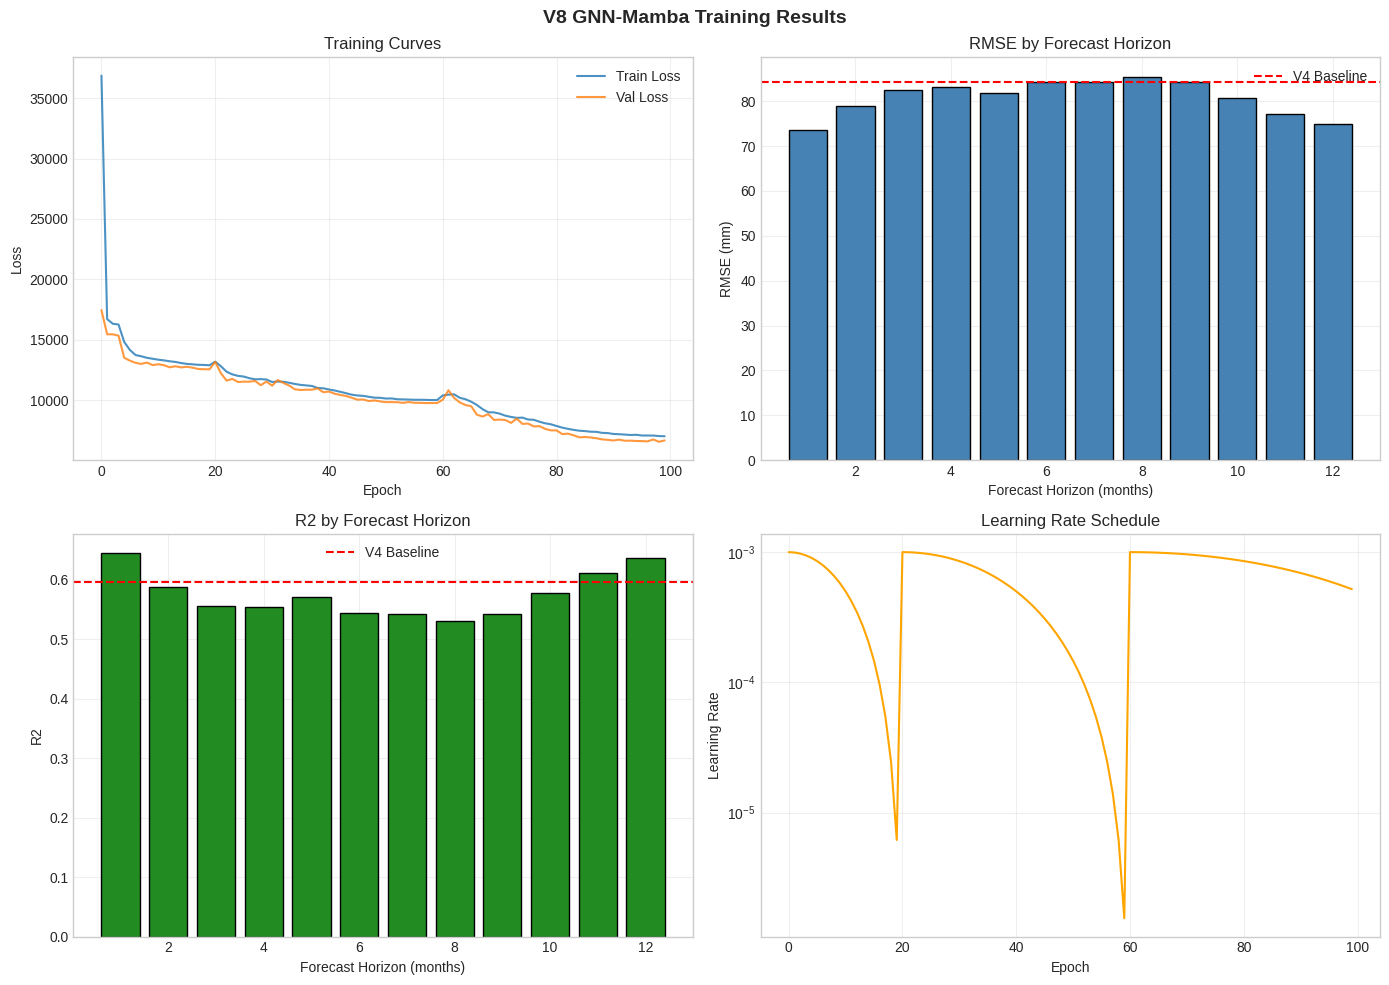

Results summary saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V8_GNN_Mamba/figures/v8_results_summary.png
Metrics summary table saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V8_GNN_Mamba/comparisons/v8_metrics_summary_table.png
Map exports saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V8_GNN_Mamba/map_exports/H1


In [15]:
# ============================================================
# SECTION 8.1: VISUALIZATION
# ============================================================

# Ensure required artifacts are initialized
if 'history' not in globals():
    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'lr': []}
    history_path = TRAIN_LOG_DIR / 'v8_training_log.csv'
    if history_path.exists():
        history_df = pd.read_csv(history_path)
        n_epochs = len(history_df)
        history = {
            'train_loss': history_df['train_loss'].tolist(),
            'val_loss': history_df['val_loss'].tolist(),
            'train_mse': history_df['train_mse'].tolist() if 'train_mse' in history_df else [float('nan')] * n_epochs,
            'val_mse': history_df['val_mse'].tolist() if 'val_mse' in history_df else [float('nan')] * n_epochs,
            'lr': history_df['lr'].tolist()
        }
        print(f"Loaded training history from: {history_path}")
    else:
        print('Training history not found; plots will use empty series.')

if 'eval_results' not in globals():
    metrics_path = COMP_DIR / 'v8_metrics.csv'
    preds_path = DATA_OUT_DIR / 'predictions.npy'
    targets_path = DATA_OUT_DIR / 'targets.npy'
    if metrics_path.exists() and preds_path.exists() and targets_path.exists():
        metrics_df = pd.read_csv(metrics_path)
        eval_results = {
            'metrics': metrics_df.to_dict(orient='records'),
            'predictions': np.load(preds_path),
            'targets': np.load(targets_path)
        }
        print(f"Loaded eval_results from: {metrics_path}")
    else:
        raise RuntimeError('eval_results not found. Run evaluation before visualization.')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Training curves
ax1 = axes[0, 0]
ax1.plot(history['train_loss'], label='Train Loss', alpha=0.8)
ax1.plot(history['val_loss'], label='Val Loss', alpha=0.8)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. RMSE by horizon
ax2 = axes[0, 1]
horizons = [m['H'] for m in eval_results['metrics']]
rmses = [m['RMSE'] for m in eval_results['metrics']]
ax2.bar(horizons, rmses, color='steelblue', edgecolor='black')
ax2.axhline(y=84.37, color='red', linestyle='--', label='V4 Baseline')
ax2.set_xlabel('Forecast Horizon (months)')
ax2.set_ylabel('RMSE (mm)')
ax2.set_title('RMSE by Forecast Horizon')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. R2 by horizon
ax3 = axes[1, 0]
r2s = [m['R^2'] for m in eval_results['metrics']]
ax3.bar(horizons, r2s, color='forestgreen', edgecolor='black')
ax3.axhline(y=0.596, color='red', linestyle='--', label='V4 Baseline')
ax3.set_xlabel('Forecast Horizon (months)')
ax3.set_ylabel('R2')
ax3.set_title('R2 by Forecast Horizon')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Learning rate schedule
ax4 = axes[1, 1]
ax4.plot(history['lr'], color='orange')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Learning Rate')
ax4.set_title('Learning Rate Schedule')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

plt.suptitle('V8 GNN-Mamba Training Results', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save figure
fig_path = FIG_OUT_DIR / 'v8_training_results.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"Figure saved to: {fig_path}")

plt.show()

# Results summary plot
metrics_df = pd.DataFrame(eval_results['metrics'])
if getattr(CONFIG, 'plot_results_summary', True):
    pred_flat = eval_results['predictions'].reshape(-1)
    targ_flat = eval_results['targets'].reshape(-1)
    rng = np.random.default_rng(SEED)
    sample_size = min(50000, pred_flat.size)
    sample_idx = rng.choice(pred_flat.size, size=sample_size, replace=False)
    pred_s = pred_flat[sample_idx]
    targ_s = targ_flat[sample_idx]
    err = pred_flat - targ_flat

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    ax1 = axes[0, 0]
    ax1.scatter(targ_s, pred_s, s=5, alpha=0.2, color='steelblue')
    lims = [min(targ_s.min(), pred_s.min()), max(targ_s.max(), pred_s.max())]
    ax1.plot(lims, lims, 'k--', linewidth=1)
    ax1.set_xlabel('Target (mm)')
    ax1.set_ylabel('Prediction (mm)')
    ax1.set_title('Pred vs Target (sample)')
    ax1.grid(True, alpha=0.3)

    ax2 = axes[0, 1]
    ax2.hist(err, bins=50, color='slategray', edgecolor='black')
    ax2.set_xlabel('Prediction Error (mm)')
    ax2.set_ylabel('Count')
    ax2.set_title('Error Distribution')
    ax2.grid(True, alpha=0.3)

    ax3 = axes[1, 0]
    ax3.plot(metrics_df['H'], metrics_df['RMSE'], marker='o', label='RMSE')
    ax3.plot(metrics_df['H'], metrics_df['MAE'], marker='o', label='MAE')
    ax3.set_xlabel('Forecast Horizon (months)')
    ax3.set_ylabel('Error (mm)')
    ax3.set_title('RMSE and MAE by Horizon')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    ax4 = axes[1, 1]
    ax4.bar(metrics_df['H'], metrics_df['Bias'], color='indianred', edgecolor='black')
    ax4.axhline(y=0.0, color='black', linewidth=0.8)
    ax4.set_xlabel('Forecast Horizon (months)')
    ax4.set_ylabel('Bias (mm)')
    ax4.set_title('Bias by Horizon')
    ax4.grid(True, alpha=0.3)

    plt.suptitle('V8 GNN-Mamba Results Summary', fontsize=14, fontweight='bold')
    plt.tight_layout()
    fig_path = FIG_OUT_DIR / 'v8_results_summary.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"Results summary saved to: {fig_path}")
else:
    print('Results summary plot disabled')

# Metrics summary table
if getattr(CONFIG, 'plot_metrics_table', True):
    display_df = metrics_df.copy()
    display_df['RMSE'] = display_df['RMSE'].map(lambda x: f"{x:.2f}")
    display_df['MAE'] = display_df['MAE'].map(lambda x: f"{x:.2f}")
    display_df['R^2'] = display_df['R^2'].map(lambda x: f"{x:.4f}")
    display_df['Bias'] = display_df['Bias'].map(lambda x: f"{x:.2f}")

    fig, ax = plt.subplots(figsize=(8, 0.6 * len(display_df) + 1.5))
    ax.axis('off')
    table = ax.table(
        cellText=display_df.values.tolist(),
        colLabels=display_df.columns.tolist(),
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2)
    fig_path = COMP_DIR / 'v8_metrics_summary_table.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"Metrics summary table saved to: {fig_path}")
else:
    print('Metrics table plot disabled')

# Map exports
if getattr(CONFIG, 'generate_map_plots', True):
    if CONFIG.n_lat * CONFIG.n_lon != eval_results['predictions'].shape[1]:
        print('Map export skipped: grid shape does not match n_nodes')
    else:
        horizon = max(1, min(CONFIG.map_export_horizon, CONFIG.horizon)) - 1
        max_samples = min(CONFIG.map_export_max_samples, eval_results['predictions'].shape[0])
        export_dir = MAP_OUT_DIR / f"H{horizon + 1}"
        export_dir.mkdir(parents=True, exist_ok=True)

        for idx in range(max_samples):
            pred_map = eval_results['predictions'][idx, :, horizon].reshape(CONFIG.n_lat, CONFIG.n_lon)
            targ_map = eval_results['targets'][idx, :, horizon].reshape(CONFIG.n_lat, CONFIG.n_lon)
            err_map = np.abs(pred_map - targ_map)

            fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
            axes[0].imshow(targ_map, cmap='Blues')
            axes[0].set_title('Target')
            axes[1].imshow(pred_map, cmap='Blues')
            axes[1].set_title('Prediction')
            axes[2].imshow(err_map, cmap='Reds')
            axes[2].set_title('Absolute Error')

            for ax in axes:
                ax.axis('off')

            fig_path = export_dir / f"sample_{idx + 1}_H{horizon + 1}.png"
            fig.savefig(fig_path, dpi=150, bbox_inches='tight')
            plt.close(fig)

        print(f"Map exports saved to: {export_dir}")
else:
    print('Map export disabled')

In [16]:
# ============================================================
# SECTION 8.2: SAVE RESULTS
# ============================================================

# Ensure evaluation artifacts are available
if 'eval_results' not in globals():
    metrics_path = COMP_DIR / 'v8_metrics.csv'
    preds_path = DATA_OUT_DIR / 'predictions.npy'
    targets_path = DATA_OUT_DIR / 'targets.npy'
    if metrics_path.exists() and preds_path.exists() and targets_path.exists():
        metrics_df = pd.read_csv(metrics_path)
        eval_results = {
            'metrics': metrics_df.to_dict(orient='records'),
            'predictions': np.load(preds_path),
            'targets': np.load(targets_path)
        }
        print(f"Loaded eval_results from: {metrics_path}")
    else:
        raise RuntimeError('eval_results not found. Run evaluation before saving results.')

history_available = 'history' in globals()
if not history_available and getattr(CONFIG, 'export_history', True):
    history_path = TRAIN_LOG_DIR / 'v8_training_log.csv'
    if history_path.exists():
        history_df = pd.read_csv(history_path)
        n_epochs = len(history_df)
        history = {
            'train_loss': history_df['train_loss'].tolist(),
            'val_loss': history_df['val_loss'].tolist(),
            'train_mse': history_df['train_mse'].tolist() if 'train_mse' in history_df else [float('nan')] * n_epochs,
            'val_mse': history_df['val_mse'].tolist() if 'val_mse' in history_df else [float('nan')] * n_epochs,
            'lr': history_df['lr'].tolist()
        }
        history_available = True
        print(f"Loaded training history from: {history_path}")
    else:
        print('Training history not found; skipping training log export.')

# Save metrics
metrics_df = pd.DataFrame(eval_results['metrics'])
metrics_df.to_csv(COMP_DIR / 'v8_metrics.csv', index=False)

if 'avg_rmse' not in globals():
    avg_rmse = float(np.mean([m['RMSE'] for m in eval_results['metrics']]))
if 'avg_mae' not in globals():
    avg_mae = float(np.mean([m['MAE'] for m in eval_results['metrics']]))
if 'avg_r2' not in globals():
    avg_r2 = float(np.mean([m['R^2'] for m in eval_results['metrics']]))
if 'r2_change' not in globals():
    r2_change = (avg_r2 - 0.596) / 0.596 * 100
if 'rmse_change' not in globals():
    rmse_change = (84.37 - avg_rmse) / 84.37 * 100

# Save training history
if getattr(CONFIG, 'export_history', True) and history_available:
    history_df = pd.DataFrame({
        'epoch': np.arange(1, len(history['train_loss']) + 1),
        'train_loss': history['train_loss'],
        'val_loss': history['val_loss'],
        'train_mse': history['train_mse'],
        'val_mse': history['val_mse'],
        'lr': history['lr']
    })
    history_df.to_csv(TRAIN_LOG_DIR / 'v8_training_log.csv', index=False)

# Save predictions and targets
if getattr(CONFIG, 'export_predictions', True):
    np.save(DATA_OUT_DIR / 'predictions.npy', eval_results['predictions'])
    np.save(DATA_OUT_DIR / 'targets.npy', eval_results['targets'])

    meta = {
        'n_samples': int(eval_results['predictions'].shape[0]),
        'n_nodes': int(eval_results['predictions'].shape[1]),
        'horizon': int(CONFIG.horizon),
        'n_lat': int(CONFIG.n_lat),
        'n_lon': int(CONFIG.n_lon)
    }
    with open(DATA_OUT_DIR / 'metadata.json', 'w') as f:
        json.dump(meta, f, indent=2)

# Save data report
if 'data_report' in globals():
    with open(OUTPUT_ROOT / 'v8_data_report.json', 'w') as f:
        json.dump(data_report, f, indent=2)

# Save quality checks
if 'quality' in globals():
    with open(OUTPUT_ROOT / 'v8_quality_checks.json', 'w') as f:
        json.dump(quality, f, indent=2)

# Save config
with open(OUTPUT_ROOT / 'v8_config.json', 'w') as f:
    json.dump(asdict(CONFIG), f, indent=2)

# Save environment info
env_info = {
    'python': sys.version,
    'torch': torch.__version__,
    'cuda': torch.version.cuda
}
try:
    import torch_geometric
    env_info['torch_geometric'] = torch_geometric.__version__
except Exception:
    pass
try:
    import mamba_ssm
    env_info['mamba_ssm'] = mamba_ssm.__version__
except Exception:
    pass

with open(OUTPUT_ROOT / 'v8_env.json', 'w') as f:
    json.dump(env_info, f, indent=2)

# Save summary
summary = {
    'model': 'V8 GNN-Mamba',
    'date': datetime.now().isoformat(),
    'config': asdict(CONFIG),
    'results': {
        'avg_rmse': float(avg_rmse),
        'avg_mae': float(avg_mae),
        'avg_r2': float(avg_r2),
        'metrics_by_horizon': eval_results['metrics']
    },
    'comparison': {
        'v4_baseline': {'r2': 0.596, 'rmse': 84.37},
        'v8_mamba': {'r2': float(avg_r2), 'rmse': float(avg_rmse)},
        'improvement': {
            'r2_percent': float(r2_change),
            'rmse_percent': float(rmse_change)
        }
    },
    'quality_checks': quality if 'quality' in globals() else None,
    'data_report': data_report if 'data_report' in globals() else None
}

with open(OUTPUT_ROOT / 'v8_summary.json', 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"\nResults saved to: {OUTPUT_ROOT}")
print('  - v8_metrics.csv')
print('  - v8_summary.json')
print('  - v8_config.json')
print('  - v8_env.json')
print('  - v8_data_report.json')
print('  - v8_quality_checks.json')
print('  - v8_training_log.csv')
print('  - v8_training_results.png')
print('  - v8_results_summary.png')
print('  - v8_metrics_summary_table.png')
print('  - v8_graph_diagnostics.png')
print('  - predictions.npy')
print('  - targets.npy')
print('  - metadata.json')
print('  - v8_best.pt')


Results saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V8_GNN_Mamba
  - v8_metrics.csv
  - v8_summary.json
  - v8_config.json
  - v8_env.json
  - v8_data_report.json
  - v8_quality_checks.json
  - v8_training_log.csv
  - v8_training_results.png
  - v8_results_summary.png
  - v8_metrics_summary_table.png
  - v8_graph_diagnostics.png
  - predictions.npy
  - targets.npy
  - metadata.json
  - v8_best.pt


In [17]:
# ============================================================
# SECTION 8.3: COLAB DISCONNECT
# ============================================================

if IN_COLAB:
    try:
        from google.colab import runtime
        runtime.unassign()
        print('Colab runtime disconnected.')
    except Exception as exc:
        print(f"Colab runtime disconnect failed: {exc}")
else:
    print('Not running in Colab; skip disconnect.')


Colab runtime disconnected.


## 9. Conclusions

### V8 GNN-Mamba Summary

This notebook implemented the V8 architecture combining:
- **Graph Neural Networks** for spatial encoding
- **Mamba State Space Models** for temporal encoding
- **Cross-Modal Attention** for feature fusion

### Key Innovations
1. First application of Mamba SSM to regional precipitation prediction
2. Selective memory mechanism for capturing seasonal patterns
3. Efficient O(n) complexity for 60-month input sequences

### Next Steps
1. Ablation studies (Mamba vs LSTM, bidirectional vs unidirectional)
2. Physics loss refinement
3. Ensemble with V4 baseline